In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import ndcg_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRanker

# 1 - Загрузка и просмотр данных


In [3]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
print(train_df.shape, test_df.shape)
train_df.head()

(15081, 81) (1529, 81)


,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,758,9,0,0,1,20,3,40,0,3,...,0.204682,0.271755,0.055623,0,0,0,0.38648,0.0,0.0,0
1,758,9,0,0,1,20,3,40,0,3,...,0.195531,0.188787,0.036914,0,0,0,0.10982,0.0,0.0,0
2,758,9,0,0,1,20,3,40,0,3,...,0.148609,0.186517,0.027718,0,0,0,0.03674,0.0,0.0,0
3,758,9,0,0,1,20,3,40,0,3,...,0.223748,0.229039,0.051247,0,0,0,0.00000,0.0,0.0,0
4,758,9,0,0,1,20,3,40,0,3,...,0.170935,0.249031,0.042568,0,0,0,0.00000,0.0,0.0,0


In [4]:
# Проверим наличие пропущенных значений
print(train_df.isnull().sum(), test_df.isnull().sum())

search_id     0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_75    0
feature_76    0
feature_77    0
feature_78    0
target        0
Length: 81, dtype: int64 search_id     0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_75    0
feature_76    0
feature_77    0
feature_78    0
target        0
Length: 81, dtype: int64


Пропущенные значения отсутствуют в обоих наборах данных. Поэтому можно переходить к следующему шагу.

# 2 - Подготовка данных

In [5]:
X_train = train_df.drop(columns=['search_id', 'target'])
y_train = train_df['target']
X_test = test_df.drop(columns=['search_id', 'target'])
y_test = test_df['target']

# Нормализация признаков
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_train)

X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = pd.DataFrame(X_train_normalized, 
                                  columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized,
                                 columns=X_test.columns)


# 3 - Обучение моделей

В обучении моделей будем использовать следующие алгоритмы:
- Градиентный бустинг 
- XGBRanker 

Для каждого алгоритма будем подбирать гиперпараметры с помощью случайного поиска.

## 3.1 - Градиентный бустинг

Градиентный бустинг - это метод построения композиций базовых моделей с помощью последовательного добавления к текущей композиции новой модели с учетом ошибки предыдущей композиции. В качестве базовой модели используется решающее дерево.

In [12]:
def random_search(model, param_grid, X_train, y_train, X_test, y_test, n_iter=10):
    best_score = float('-inf')
    best_params = None
    for i in range(n_iter):  # Количество итераций для случайного поиска
        params = {param: np.random.choice(values) for param, values in param_grid.items()}
        
        # Оценка параметров
        model.set_params(**params)
        try:
            model.fit(X_train, y_train)
        except ValueError:
            model.fit(X_train, y_train, group=train_df.groupby('search_id').size().values)
        scores = model.predict(X_test)
        score = ndcg_score([y_test], [scores])
        
        print('NDCG score: ', score, 'params: ', params, 'iter: ', i+1)
        if score > best_score:
            best_score = score
            best_params = params

    print("Best parameters found: ", best_params, "with NDCG score: ", best_score)
    return best_params, best_score

In [3]:
param_grid = {
    'learning_rate': np.linspace(0.00005, 0.1, 10), 
    'n_estimators': np.random.randint(50, 300, 10),
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['sqrt', 'log2', None],
}

model = GradientBoostingRegressor()
best_params, best_score = random_search(model, param_grid,
                                        X_train_normalized, y_train,
                                        X_test_normalized, y_test)

Best parameters found:  {'learning_rate': 0.06668333333333333, 'n_estimators': 136, 'max_depth': 1, 'min_samples_leaf': 7, 'max_features': None} with NDCG score:  0.6736194918991895

In [7]:
# Обучение модели с найденными параметрами
model = GradientBoostingRegressor(n_estimators=136, learning_rate=0.067, max_depth=1, min_samples_leaf=7, max_features=None)
model.fit(X_train_normalized, y_train)
scores = model.predict(X_test_normalized)
print(ndcg_score([y_test], [scores]))

0.6736269204592273


Используя найденные параметры, получили значение NDCG метрики равное 0.6736. Теперь перейдем к обучению модели XGBRanker.

## 3.2 - XGBRanker

XGBRanker - это реализация градиентного бустинга, которая позволяет обучать модель на ранжирование. В качестве функции потерь используется NDCG.

In [5]:
param_grid = {
    'learning_rate': np.linspace(0.00005, 0.1, 100), 
    'max_depth': np.arange(2, 10),
    'n_estimators': np.random.randint(50, 175, 10),
    'gamma': [0, 0.01, 0.02, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.001, 0.002, 0.003, 0.004, 0.005],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8],
}

ranker = XGBRanker(objective="rank:ndcg", group=train_df.groupby('search_id').size().value)
best_params, best_score = random_search(ranker, param_grid,
                                        X_train_normalized, y_train,
                                        X_test_normalized, y_test)

Best parameters found:  {'learning_rate': 0.004088383838383838, 'max_depth': 2, 'n_estimators': 50, 'gamma': 0.003, 'min_child_weight': 3} with NDCG score:  0.660601519976541

In [8]:
# Обучение модели с найденными параметрами
ranker = XGBRanker(objective="rank:ndcg", n_estimators=50, learning_rate=0.0041, max_depth=2, gamma=0.003, min_child_weight=3)
ranker.fit(X_train_normalized, y_train, group=train_df.groupby('search_id').size().values)
scores = ranker.predict(X_test_normalized)
print(ndcg_score([y_test], [scores]))

0.660601519976541


Используя найденные параметры, получили значение NDCG метрики равное 0.6606. 

# 4 - PCA (principal component analysis)

Попробуем уменьшить размерность данных с помощью метода главных компонент.

In [ ]:
n = int(input())
arr = list(map(int, input().split()))
result = ""
i = 0
while arr[i] % 2 == 0:
    result += "+"
    i += 1
for j in range(i+1, n):
    if arr[j] % 2 == 0:
        result += "+"
    else:
        result += "x"

print(result)


In [9]:
pca = PCA(n_components=0.95)
print(X_train_normalized.shape, X_test_normalized.shape)
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

print(X_train_pca.shape, X_test_pca.shape)

(15081, 79) (1529, 79)
(15081, 53) (1529, 53)


Можно заметить, что размерность данных была уменьшена с 79 до 53. Теперь обучим модели с новыми данными.

In [ ]:
param_grid = {
    'learning_rate': np.linspace(0.001, 0.1, 100), 
    'n_estimators': np.random.randint(50, 300, 10),
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['sqrt', 'log2', None],
}

model = GradientBoostingRegressor()
best_params, best_score = random_search(model, param_grid,
                                        X_train_pca, y_train,
                                        X_test_pca, y_test)

Best parameters found:  {'learning_rate': 0.012, 'n_estimators': 169, 'max_depth': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt'} with NDCG score:  0.4628962865023646

In [27]:
param_grid = {
    'learning_rate': np.linspace(0.00005, 0.1, 100), 
    'max_depth': np.arange(2, 10),
    'n_estimators': np.random.randint(50, 250, 100),
    'gamma': [0, 0.01, 0.02, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.001, 0.002, 0.003, 0.004, 0.005],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8],
}

ranker = XGBRanker(objective="rank:ndcg")
best_params, best_score = random_search(ranker, param_grid,
                                        X_train_pca, y_train,
                                        X_test_pca, y_test)

NDCG score:  0.44102710906678366 params:  {'learning_rate': 0.03740505050505051, 'max_depth': 3, 'n_estimators': 40, 'gamma': 0.1, 'min_child_weight': 4} iter:  1
NDCG score:  0.41441857411043154 params:  {'learning_rate': 0.045481818181818186, 'max_depth': 7, 'n_estimators': 194, 'gamma': 0.2, 'min_child_weight': 8} iter:  2
NDCG score:  0.4379202510473297 params:  {'learning_rate': 0.08788484848484848, 'max_depth': 9, 'n_estimators': 84, 'gamma': 0.0, 'min_child_weight': 6} iter:  3
NDCG score:  0.46902870965541227 params:  {'learning_rate': 0.07173131313131313, 'max_depth': 7, 'n_estimators': 86, 'gamma': 0.3, 'min_child_weight': 6} iter:  4
NDCG score:  0.417166034701307 params:  {'learning_rate': 0.023270707070707074, 'max_depth': 2, 'n_estimators': 81, 'gamma': 0.003, 'min_child_weight': 3} iter:  5
NDCG score:  0.47537276593078565 params:  {'learning_rate': 0.0798080808080808, 'max_depth': 9, 'n_estimators': 148, 'gamma': 0.005, 'min_child_weight': 2} iter:  6
NDCG score:  0.440

Best parameters found:  {'learning_rate': 0.023270707070707074, 'max_depth': 6, 'n_estimators': 124, 'gamma': 0.003, 'min_child_weight': 5} with NDCG score:  0.501515990479487

Выполнение PCA привело к ухудшению качества моделей. Поэтому в дальнейшем будем использовать исходные данные.

# 5 - Важность признаков

Чтобы понять, какие признаки вносят наибольший вклад в модель, построим график важности признаков для модели градиентного бустинга и XGBRanker.

Графики строим на уже полученных гиперпараметрах.


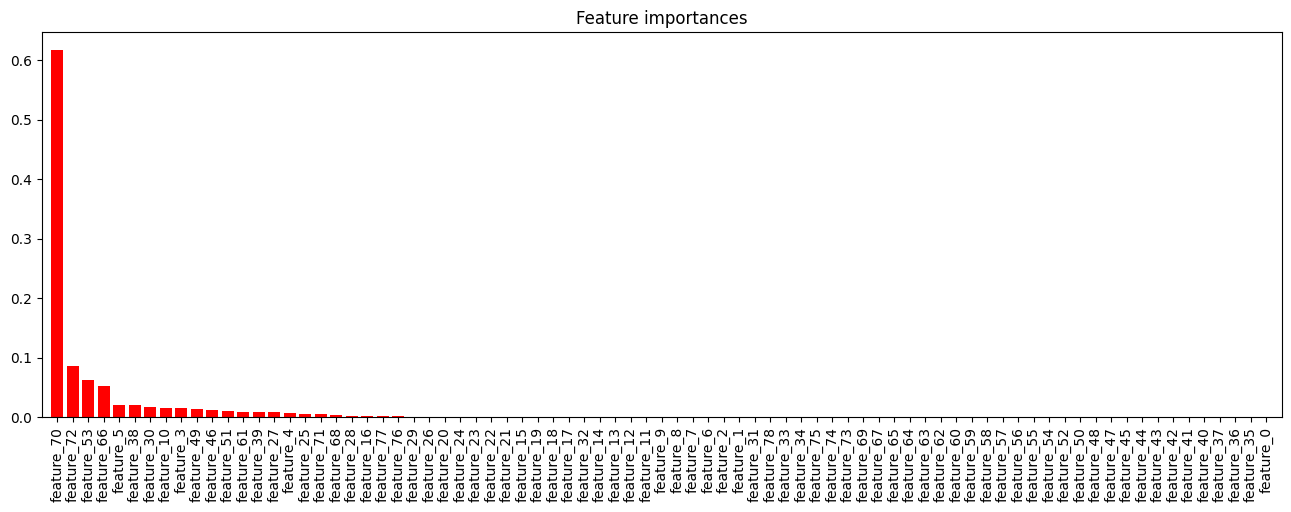

In [63]:
model = GradientBoostingRegressor(n_estimators=136, learning_rate=0.067, max_depth=1, min_samples_leaf=7, max_features=None)
model.fit(X_train_normalized, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 5))
plt.title("Feature importances")
plt.bar(range(X_train_normalized.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train_normalized.shape[1]), X_train_normalized.columns[indices], rotation=90)
plt.xlim([-1, X_train_normalized.shape[1]])
plt.show()



Из графика видно, что наибольший вклад вноясят лишь некоторые признаки. Попробуем обучить модель, используя только 23 наиболее важных признака.

In [66]:
X_train_normalized.columns[indices[:23]]

Index(['feature_70', 'feature_72', 'feature_53', 'feature_66', 'feature_5',
       'feature_38', 'feature_30', 'feature_10', 'feature_3', 'feature_49',
       'feature_46', 'feature_51', 'feature_61', 'feature_39', 'feature_27',
       'feature_4', 'feature_25', 'feature_71', 'feature_68', 'feature_28',
       'feature_16', 'feature_77', 'feature_76'],
      dtype='object')

In [22]:
model = GradientBoostingRegressor(n_estimators=136, learning_rate=0.067, max_depth=1, min_samples_leaf=7, max_features=None)
model.fit(X_train_normalized[X_train_normalized.columns[indices[:23]]], y_train)
scores = model.predict(X_test_normalized[X_train_normalized.columns[indices[:23]]])
print(ndcg_score([y_test], [scores]))

0.6707012963992246


Используя только 23 признака, получили значение NDCG метрики равное 0.6707. Это означает, что можно использовать только эти признаки для обучения модели, что уменьшит скорость предсказания.

Проверим, какие признаки важны для модели XGBRanker.

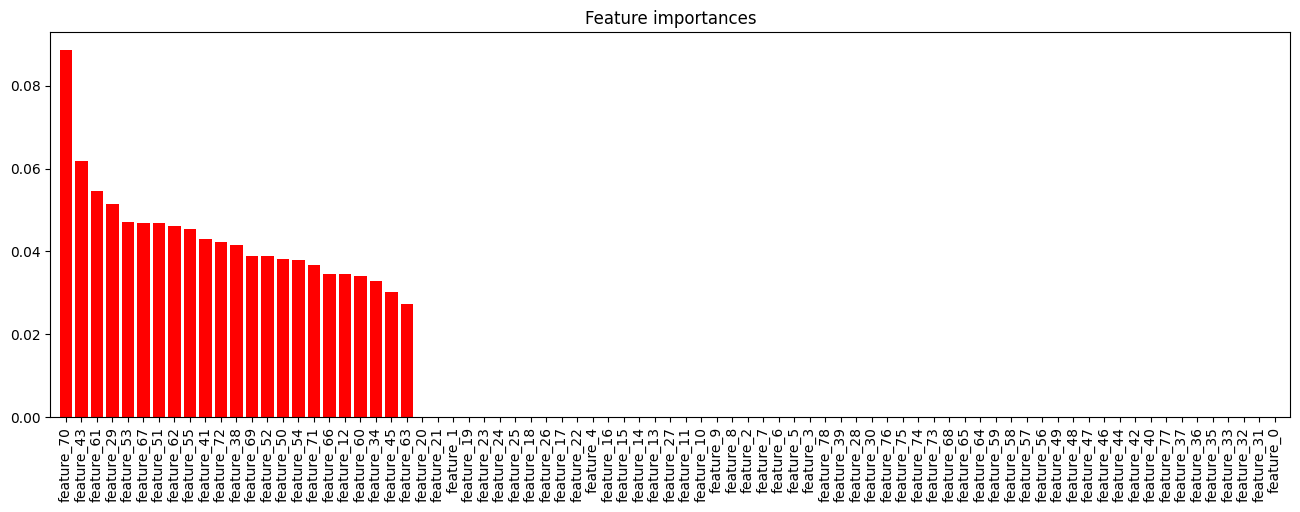

In [59]:
ranker = XGBRanker(objective="rank:ndcg", n_estimators=50, learning_rate=0.0041, max_depth=2, gamma=0.003, min_child_weight=3)
ranker.fit(X_train_normalized, y_train, group=train_df.groupby('search_id').size().values)
importances = ranker.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 5))
plt.title("Feature importances")
plt.bar(range(X_train_normalized.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train_normalized.shape[1]), X_train_normalized.columns[indices], rotation=90)
plt.xlim([-1, X_train_normalized.shape[1]])
plt.show()

In [60]:
X_train_normalized.columns[indices[:23]]

Index(['feature_70', 'feature_43', 'feature_61', 'feature_29', 'feature_53',
       'feature_67', 'feature_51', 'feature_62', 'feature_55', 'feature_41',
       'feature_72', 'feature_38', 'feature_69', 'feature_52', 'feature_50',
       'feature_54', 'feature_71', 'feature_66', 'feature_12', 'feature_60',
       'feature_34', 'feature_45', 'feature_63'],
      dtype='object')

In [39]:
ranker = XGBRanker(objective="rank:ndcg", n_estimators=50, learning_rate=0.0041, max_depth=2, gamma=0.003, min_child_weight=3)
ranker.fit(X_train_normalized[X_train_normalized.columns[indices[:23]]], y_train, group=train_df.groupby('search_id').size().values)
scores = ranker.predict(X_test_normalized[X_train_normalized.columns[indices[:23]]])
print(ndcg_score([y_test], [scores]))

0.660601519976541


Снова используя только 23 признака, получили значение NDCG метрики равное 0.6606. Что в точности совпадает с результатом, полученным при использовании всех признаков.

# 6 - Дополнительные методы

Попробуем обучить модели с помощью случайного леса.


In [68]:
param_grid = {
    'n_estimators': np.random.randint(50, 300, 10),
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['sqrt', 'log2', None],
}

model = RandomForestRegressor()
best_params, best_score = random_search(model, param_grid,
                                        X_train_normalized, y_train,
                                        X_test_normalized, y_test, n_iter=100)


NDCG score:  0.5341204484995297 params:  {'n_estimators': 253, 'max_depth': 4, 'min_samples_leaf': 5, 'max_features': None} iter:  1
NDCG score:  0.5082637445516984 params:  {'n_estimators': 79, 'max_depth': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'} iter:  2
NDCG score:  0.5069121265179809 params:  {'n_estimators': 184, 'max_depth': 8, 'min_samples_leaf': 4, 'max_features': 'log2'} iter:  3
NDCG score:  0.5014451989438589 params:  {'n_estimators': 258, 'max_depth': 6, 'min_samples_leaf': 8, 'max_features': 'log2'} iter:  4
NDCG score:  0.5057793186991806 params:  {'n_estimators': 258, 'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt'} iter:  5
NDCG score:  0.47450333934575034 params:  {'n_estimators': 128, 'max_depth': 2, 'min_samples_leaf': 5, 'max_features': 'log2'} iter:  6
NDCG score:  0.5334512709928066 params:  {'n_estimators': 160, 'max_depth': 2, 'min_samples_leaf': 9, 'max_features': None} iter:  7
NDCG score:  0.5377535873479601 params:  {'n_estimators': 1

Best parameters found:  {'n_estimators': 160, 'max_depth': 6, 'min_samples_leaf': 8, 'max_features': None} with NDCG score:  0.6062950638367753

# 7 - Выводы

В ходе выполнения работы были обучены модели градиентного бустинга и XGBRanker. Для каждой модели были подобраны гиперпараметры с помощью случайного поиска. Также было выполнено уменьшение размерности данных с помощью метода главных компонент. После этого были обучены модели с новыми данными. В результате были получены следующие значения NDCG метрики:
- Градиентный бустинг: 0.6736
- XGBRanker: 0.6606
- Градиентный бустинг с использованием только 23 наиболее важных признаков: 0.6707
- XGBRanker с использованием только 23 наиболее важных признаков: 0.6606
- Случайный лес: 0.6063

Таким образом, лучшей моделью оказалась модель градиентного бустинга, обученная на всех признаках. Также было показано, что можно использовать только 23 наиболее важных признака для обучения модели, что уменьшит время обучения и скорость предсказания.

